In [1]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

#from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
#from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.qual_util import get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
import os
from termcolor import colored, cprint
import torch
import utils.util as util
from tqdm.notebook import tqdm

from datasets.ys_shapeset import  ShapeNetZSets

from datasets.text2shape import  Text2Shape





import cv2
import numpy as np
import imageio
from PIL import Image
from einops import rearrange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from pytorch3d import structures

from utils.util_3d import sdf_to_mesh, render_mesh, rotate_mesh_360





%reload_ext autoreload
%autoreload 2

# Setting Up Experiment Folder

In [2]:
seed_everything(111)

description = "bertV3/new_trasnformer"
res_dir = 'logs/new-bert/new-bert-3_1'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

In [3]:
def load_bert2vqsc_model_v0(opt):
    from models.networks.bert2vq_sc import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    #bert2vq_ckpt = '../raw_dataset/checkpoints/bert2vq_epoch-latest.pth'
    #bert2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    bert2vq_ckpt = "./logs/bert2vqsc-text2shape-seq-LR1e-4-new-bert-1/ckpt/bert2vq_epoch-latest.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net






def load_bert2vqsc_model_v1(opt):
    from models.networks.bert2vq_sc import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    bert2vq_ckpt = '../raw_dataset/checkpoints_new/bert2vq_epoch-latest.pth'
    #ber2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net

In [4]:
shapeset = ShapeNetZSets()

In [10]:
y  = shapeset[4]["z_set"]
y.shape


NameError: name 'shapeset' is not defined

In [4]:
def create_model(opt):
    model = None

    if opt.model == 'pvqvae':
        # vqvae
        from models.pvqvae_model import PVQVAEModel
        model = PVQVAEModel()
    elif opt.model == 'rand_tf':
        # transformer
        from models.rand_tf_model import RandTransformerModel
        model = RandTransformerModel()
    elif opt.model == 'rand_tf_old':
        from models.rand_tf_model_old import RandTransformerModelOld
        model = RandTransformerModelOld()
    elif opt.model == 'seq_tf':
        # seq-transformer
        from models.seq_tf_model import SeqTransformerModel
        model = SeqTransformerModel()
    elif opt.model == 'bert2vq':
        from models.bert2vq_model import BERT2VQModel
        model = BERT2VQModel()
    elif opt.model == "bert2vqsc":
        from models.bert2vq_scmodel import BERT2VQSCModel
        model = BERT2VQSCModel()
    elif opt.model == 'resnet2vq':
        from models.resnet2vq_model import ResNet2VQModel
        model = ResNet2VQModel()
    elif opt.model == 'resnet2vox':
        from models.resnet2vox_model import ResNet2VoxModel
        model = ResNet2VoxModel()
    elif opt.model == 'resnet2sdf':
        from models.resnet2sdf_model import ResNet2SDFModel
        model = ResNet2SDFModel()
    elif opt.model == 'baseline_je':
        from models.baseline_je_model import LangJEModel
        model = LangJEModel()
    elif opt.model == 'img_je':
        from models.img_je_model import ImgJEModel
        model = ImgJEModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)

    model.initialize(opt)
    cprint("[*] Model has been created: %s" % model.name(), 'blue')
    if(opt.ckpt is not None):
        model.load_ckpt(opt.ckpt)
        print("MODEL LOADED")
    return model

In [5]:
def get_shape_comp_opt(gpu_id=0):
    opt = Opt()

    # args
    gpuid=[gpu_id]
    batch_size=1
    max_dataset_size=10000000

    name='test_transformer'

    # default args
    opt.serial_batches = False
    opt.nThreads = 4

    # important args
    opt.dataset_mode = 'shapenet_code'
    opt.seed = 111
    opt.isTrain = False
    opt.gpu_ids = gpuid
    opt.device = 'cuda:%s' % gpuid[0]
    opt.batch_size = batch_size
    opt.max_dataset_size = max_dataset_size

    opt.name = name

    #utils.util.seed_everything(opt.seed)
    opt.phase = 'test'
    return opt




def get_shape_comp_model(opt, model, ckpt):
    
    # load tf stuff
    opt.model=model
    opt.tf_cfg='configs/rand_tf_snet_code.yaml'
    opt.ckpt = ckpt
    
    # load vq stuff
    opt.vq_model='pvqvae'
    opt.vq_cfg='configs/pvqvae_snet.yaml'
    opt.vq_ckpt='../raw_dataset/checkpoints/vqvae.pth'
    
    ### opt.vq_dset='sdf_code' # original
    opt.vq_dset='snet'

    model = create_model(opt)
    print(f'[*] "{opt.model}" initialized.')
    model.load_ckpt(opt.ckpt)
        
    return model

# Loading Transformer Models V0 -> V5

In [6]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"

#new_checkpoint_path = "logs/valid-valid-with-fusion-rand_tf-owndataset-chair-LR1e-4-clean-with-ckpt/ckpt/rand_tf_epoch-latest.pth"
new_checkpoint_path_V1 = "../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth"
new_checkpoint_path_V2="../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_v2.pth"
new_checkpoint_path_V3 = "../raw_dataset/checkpoints_new/rand_tf_epoch_0_fusion_v3.pth"
new_checkpoint_path_V5 = "../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth"


# modelV0 = get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints/rand_tf_singles_best.pth")    
# modelV0.eval()

# modelV4 =  get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints_new/rand_tf_250_epochs_v4.pth")
# modelV4.eval()

#modelV1 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V1) 
#modelV1.eval()

# modelV2 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V2)
# modelV2.eval()

# modelV3 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V3)
# modelV3.eval()

modelV5 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V5)
modelV5.eval()



[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth


/rhome/streakfull/.cache/pypoetry/virtualenvs/adl4cv-I-Koul65-py3.8/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth


# Loading Bert Models V0,V1

In [7]:
""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)


def load_bert2vqsc_model_v3(opt):
    from models.networks.bert2vq_sc import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    #bert2vq_ckpt = '../raw_dataset/checkpoints/bert2vq_epoch-latest.pth'
    #bert2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    #bert2vq_ckpt = "./logs/bert2vqsc-text2shape-seq-LR1e-4-new-bert-1/ckpt/bert2vq_epoch-latest.pth"
    bert2vq_ckpt = "./logs/bert2vqsc-text2shape-seq-LR1e-4-new-bert-2-prev_z_shape_input-try-2/ckpt/bert2vq_epoch-latest.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net



opt.mlp_layers = 3
opt.mlp_hidden = 1024
bert2vqV3 = load_bert2vqsc_model_v3(opt)
#bert2vqV1 = load_bert2vqsc_model_v1(opt)

In [8]:
bert2vqV3

BERT2VQ(
  (bert_model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
    (2): Normalize()
  )
  (softmax): Softmax(dim=-1)
  (linear_in): Linear(in_features=384, out_features=512, bias=True)
  (convt_layers): Sequential(
    (0): ResnetBlock(
      (norm1): GroupNorm(32, 1024, eps=1e-06, affine=True)
      (conv1): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (nin_shortcut): Conv3d(1024, 512, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (1): ResnetBlock(
      (norm1): Group

# Loading Test Samples

In [10]:
with open("./test_samples_paper.txt") as file:
    sequences = [line.rstrip() for line in file]




In [11]:
sequences_clean = [0] * len(sequences)
for i in range(len(sequences)):
    seq = sequences[i]
    sequence = seq.split(",")
    sequences_clean[i] = sequence

In [11]:
sequences_clean[0]

['a high bar seat',
 'has a molded curved seat',
 'has a metal footrest and circular base']

In [11]:
seed_everything(111)

description = "CherryPick with bertV1/TransformerV5"
res_dir = 'logs/cherry-pick/exp1/1'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

In [30]:
#sequences_clean = [["a wooden chair","with thin legs","with rectangle back"]]
from copy import deepcopy
import random
import string
sequences_random = deepcopy(sequences_clean)
for i in range(len(sequence_random)):
    sequence = sequences_random[i]
    for j in range(len(sequence)):
        current_text = sequence[j]
        letters = string.ascii_lowercase
        text = ''.join(random.choice(letters) for k in range(len(current_text)))
        sequence[j] = text

sequences_random


[['rdkjrqtgylbwwmc',
  'wxvtzmzvymkmyxqogtsdobbs',
  'sdioyhkemwnkuyhftxclcsutlhkvasxstwjvoc'],
 ['psxpagipkvojgkccwouxjd', 'jebqojanmdanfss', 'ovulhegbzl'],
 ['plpbdqsjmeqr',
  'tulhosagamodww',
  'xjwtzpzdcctkmidbbkbdepjlpiavrswivkdydleifzjrwnownpvacwpkae'],
 ['zsfqnkquolluqjjgybklrplfuycdscxp',
  'rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk',
  'lrywatbkcuzelfbhwlmsjlwpyvunauqrfelbvkpdcivmtvjetf'],
 ['zmmawdxslpqzd', 'chgytwveofmric', 'kwfyrpuuyzpujplsstl'],
 ['ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj',
  'pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp',
  'mmliubhppjvvhfffyodzegjpvnwtlmrglsseozuuvdtinz'],
 ['hningswe',
  'ofctnzalgqdrkbfurjql',
  'ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq',
  'ndqaosoihiwksanczxscjgowzklraes'],
 ['btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi',
  'ziaqbhputcbtoajebufqdohvoxpabicvafowabclseaui'],
 ['zrpvtfydckjobknewwfelgrt',
  'shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni',
  'uqzgqqhpkokjvwxcvwccropu

# For Tranformer Model V1,V2,V3,V5

  0%|                                                                          | 0/13 [00:00<?, ?it/s]

rdkjrqtgylbwwmc ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: rdkjrqtgylbwwmc
Full Text: rdkjrqtgylbwwmc
Saved: logs/bertV3/transformerv5-invalid-text/0-0-modelV5-rdkjrqtgylbwwmc.gif


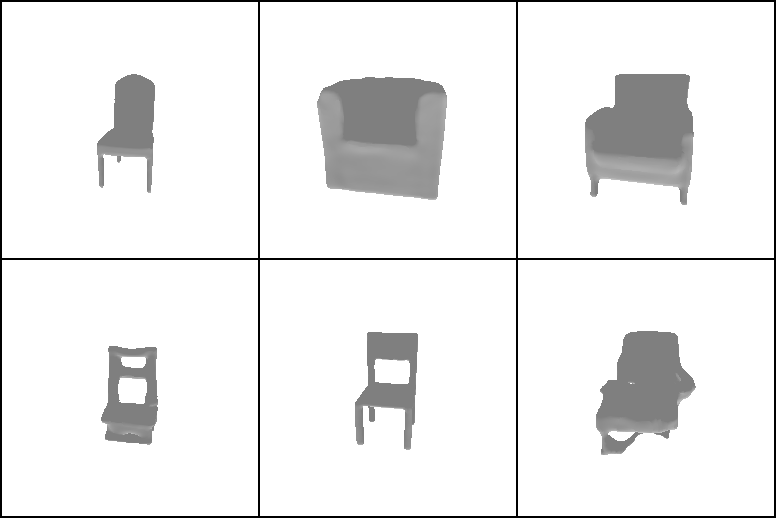

rdkjrqtgylbwwmc wxvtzmzvymkmyxqogtsdobbs ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: wxvtzmzvymkmyxqogtsdobbs
Full Text: rdkjrqtgylbwwmc wxvtzmzvymkmyxqogtsdobbs
Saved: logs/bertV3/transformerv5-invalid-text/0-1-modelV5-rdkjrqtgylbwwmc wxvtzmzvymkmyxqogtsdobbs.gif


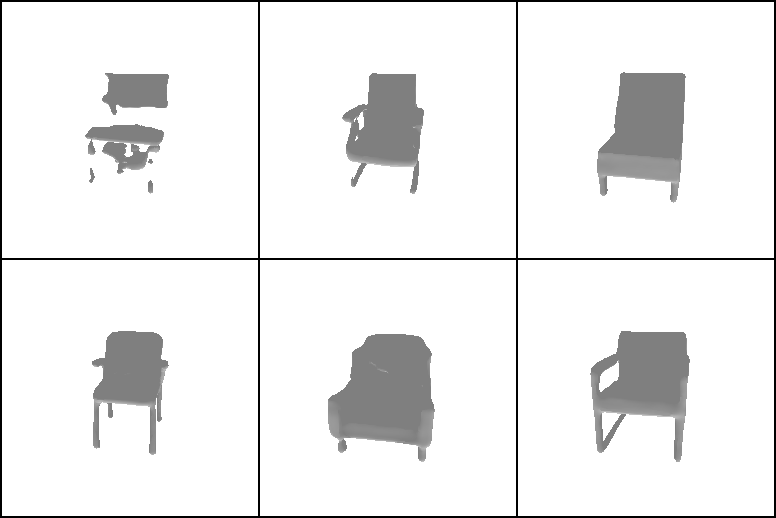

rdkjrqtgylbwwmc wxvtzmzvymkmyxqogtsdobbs sdioyhkemwnkuyhftxclcsutlhkvasxstwjvoc ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: sdioyhkemwnkuyhftxclcsutlhkvasxstwjvoc
Full Text: rdkjrqtgylbwwmc wxvtzmzvymkmyxqogtsdobbs sdioyhkemwnkuyhftxclcsutlhkvasxstwjvoc
Saved: logs/bertV3/transformerv5-invalid-text/0-2-modelV5-rdkjrqtgylbwwmc wxvtzmzvymkmyxqogtsdobbs sdioyhkemwnkuyhftxclcsutlhkvasxstwjvoc.gif


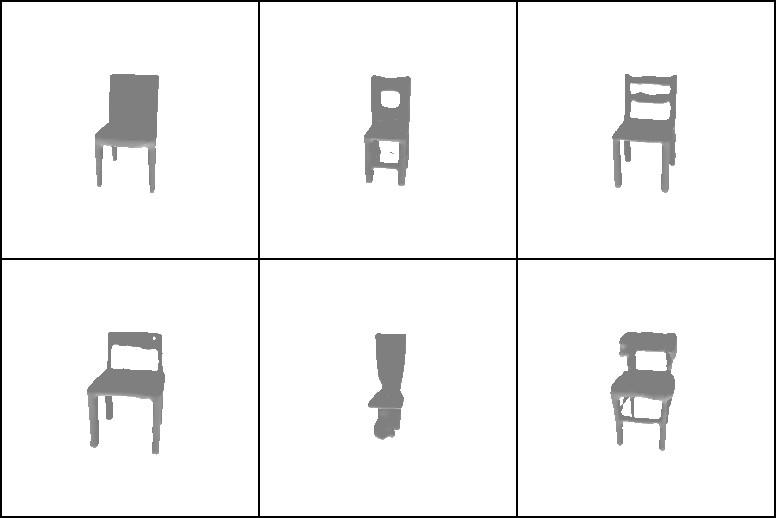

  8%|█████                                                             | 1/13 [00:21<04:16, 21.35s/it]

psxpagipkvojgkccwouxjd ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: psxpagipkvojgkccwouxjd
Full Text: psxpagipkvojgkccwouxjd
Saved: logs/bertV3/transformerv5-invalid-text/1-0-modelV5-psxpagipkvojgkccwouxjd.gif


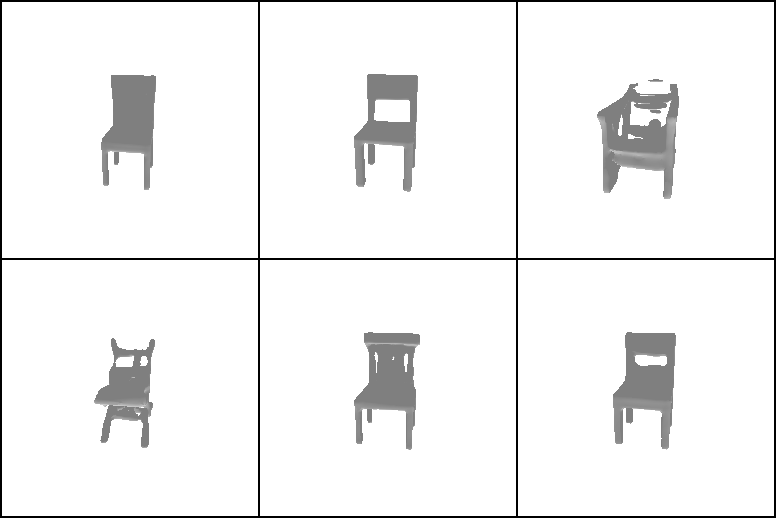

psxpagipkvojgkccwouxjd jebqojanmdanfss ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: jebqojanmdanfss
Full Text: psxpagipkvojgkccwouxjd jebqojanmdanfss
Saved: logs/bertV3/transformerv5-invalid-text/1-1-modelV5-psxpagipkvojgkccwouxjd jebqojanmdanfss.gif


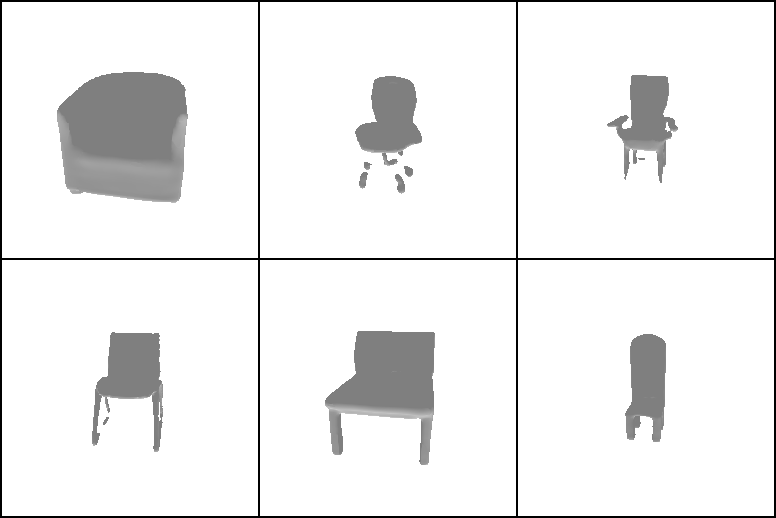

psxpagipkvojgkccwouxjd jebqojanmdanfss ovulhegbzl ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: ovulhegbzl
Full Text: psxpagipkvojgkccwouxjd jebqojanmdanfss ovulhegbzl
Saved: logs/bertV3/transformerv5-invalid-text/1-2-modelV5-psxpagipkvojgkccwouxjd jebqojanmdanfss ovulhegbzl.gif


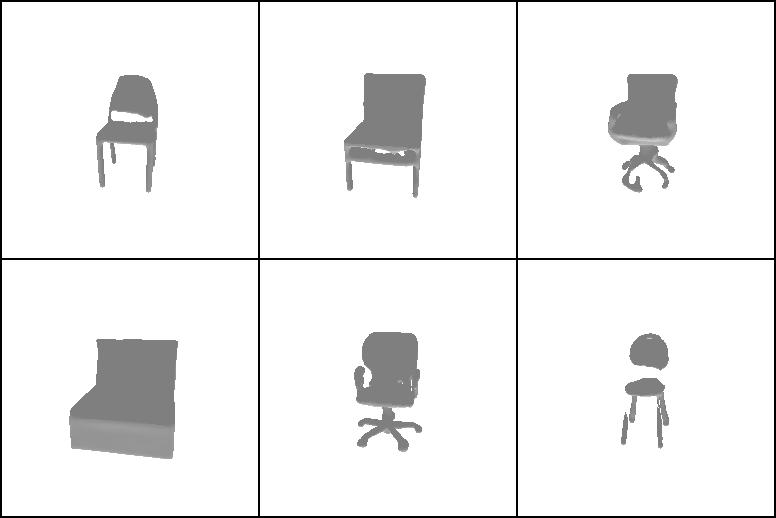

 15%|██████████▏                                                       | 2/13 [00:42<03:54, 21.32s/it]

plpbdqsjmeqr ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: plpbdqsjmeqr
Full Text: plpbdqsjmeqr
Saved: logs/bertV3/transformerv5-invalid-text/2-0-modelV5-plpbdqsjmeqr.gif


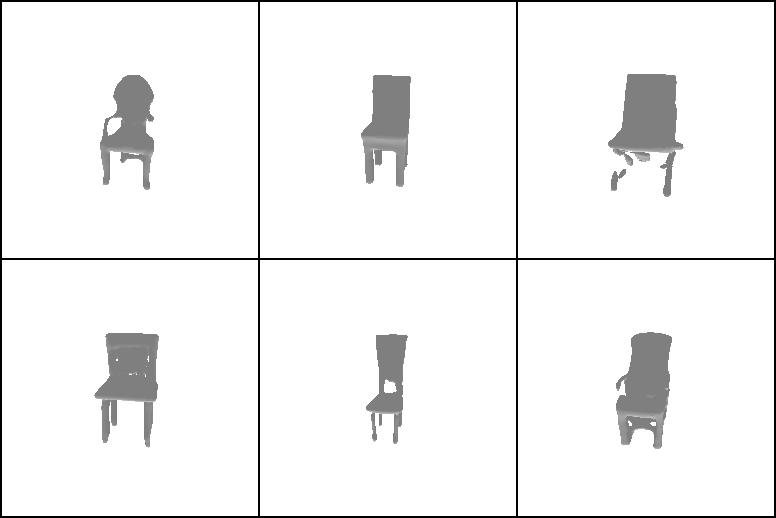

plpbdqsjmeqr tulhosagamodww ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: tulhosagamodww
Full Text: plpbdqsjmeqr tulhosagamodww
Saved: logs/bertV3/transformerv5-invalid-text/2-1-modelV5-plpbdqsjmeqr tulhosagamodww.gif


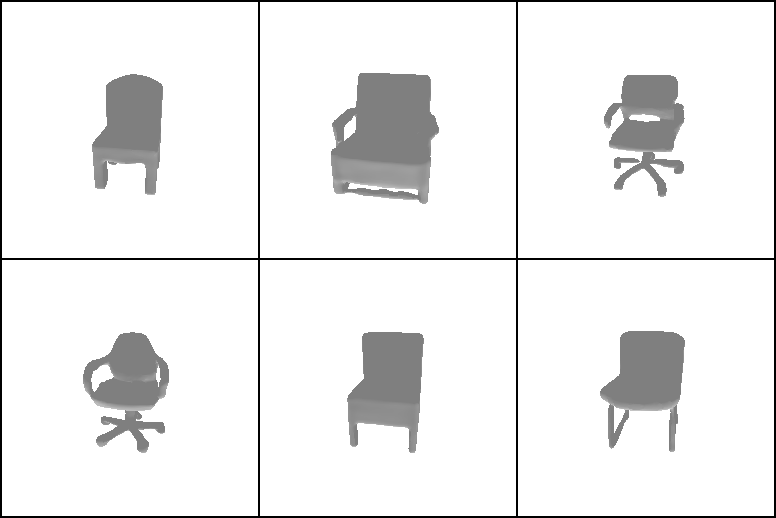

plpbdqsjmeqr tulhosagamodww xjwtzpzdcctkmidbbkbdepjlpiavrswivkdydleifzjrwnownpvacwpkae ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: xjwtzpzdcctkmidbbkbdepjlpiavrswivkdydleifzjrwnownpvacwpkae
Full Text: plpbdqsjmeqr tulhosagamodww xjwtzpzdcctkmidbbkbdepjlpiavrswivkdydleifzjrwnownpvacwpkae
Saved: logs/bertV3/transformerv5-invalid-text/2-2-modelV5-plpbdqsjmeqr tulhosagamodww xjwtzpzdcctkmidbbkbdepjlpiavrswivkdydleifzjrwnownpvacwpkae.gif


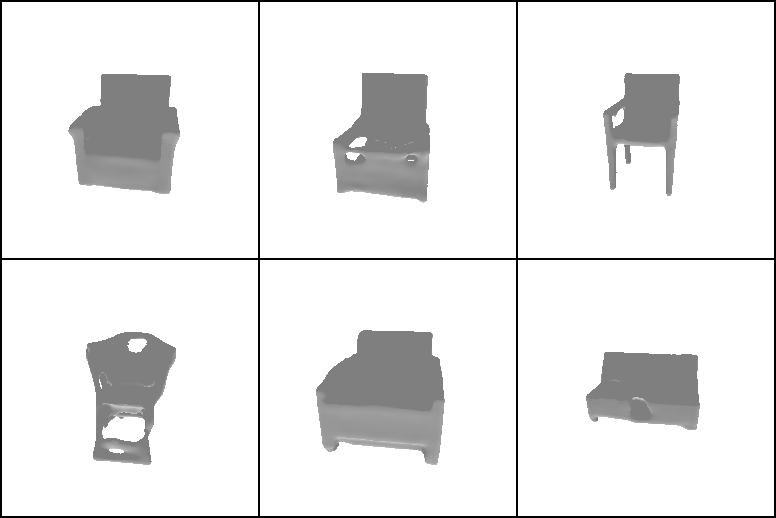

 23%|███████████████▏                                                  | 3/13 [01:03<03:33, 21.32s/it]

zsfqnkquolluqjjgybklrplfuycdscxp ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: zsfqnkquolluqjjgybklrplfuycdscxp
Full Text: zsfqnkquolluqjjgybklrplfuycdscxp
Saved: logs/bertV3/transformerv5-invalid-text/3-0-modelV5-zsfqnkquolluqjjgybklrplfuycdscxp.gif


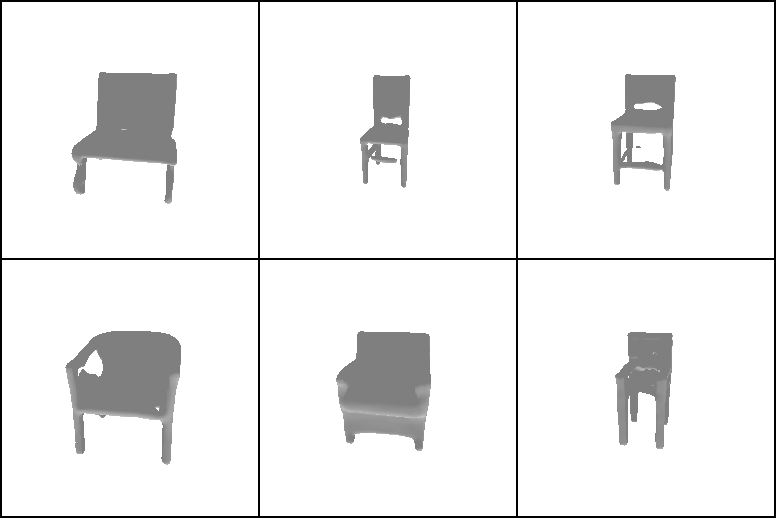

zsfqnkquolluqjjgybklrplfuycdscxp rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk
Full Text: zsfqnkquolluqjjgybklrplfuycdscxp rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk
Saved: logs/bertV3/transformerv5-invalid-text/3-1-modelV5-zsfqnkquolluqjjgybklrplfuycdscxp rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk.gif


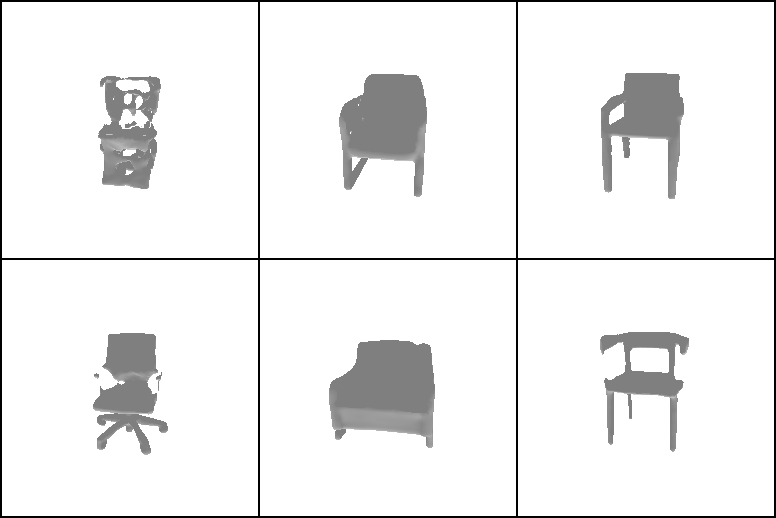

zsfqnkquolluqjjgybklrplfuycdscxp rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk lrywatbkcuzelfbhwlmsjlwpyvunauqrfelbvkpdcivmtvjetf ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: lrywatbkcuzelfbhwlmsjlwpyvunauqrfelbvkpdcivmtvjetf
Full Text: zsfqnkquolluqjjgybklrplfuycdscxp rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk lrywatbkcuzelfbhwlmsjlwpyvunauqrfelbvkpdcivmtvjetf
Saved: logs/bertV3/transformerv5-invalid-text/3-2-modelV5-zsfqnkquolluqjjgybklrplfuycdscxp rtsqqynhjslvnxqixiejpbeflrmsrgskxvesk lrywatbkcuzelfbhwlmsjlwpyvunauqrfelbvkpdcivmtvjetf.gif


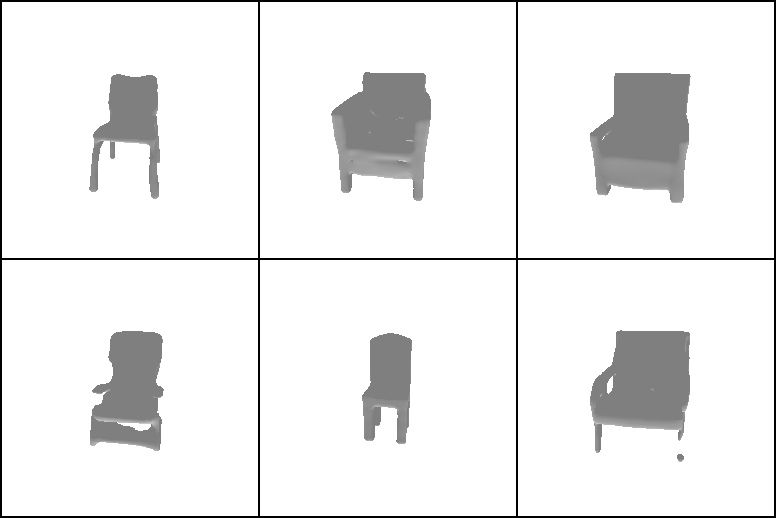

 31%|████████████████████▎                                             | 4/13 [01:25<03:11, 21.33s/it]

zmmawdxslpqzd ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: zmmawdxslpqzd
Full Text: zmmawdxslpqzd
Saved: logs/bertV3/transformerv5-invalid-text/4-0-modelV5-zmmawdxslpqzd.gif


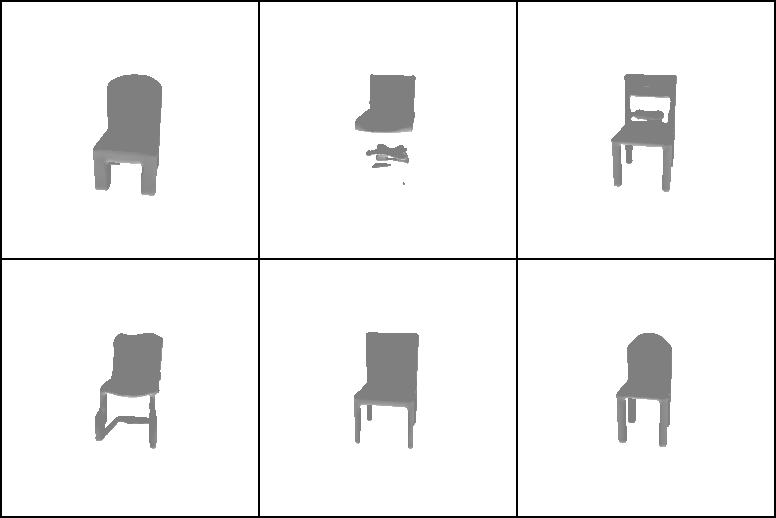

zmmawdxslpqzd chgytwveofmric ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: chgytwveofmric
Full Text: zmmawdxslpqzd chgytwveofmric
Saved: logs/bertV3/transformerv5-invalid-text/4-1-modelV5-zmmawdxslpqzd chgytwveofmric.gif


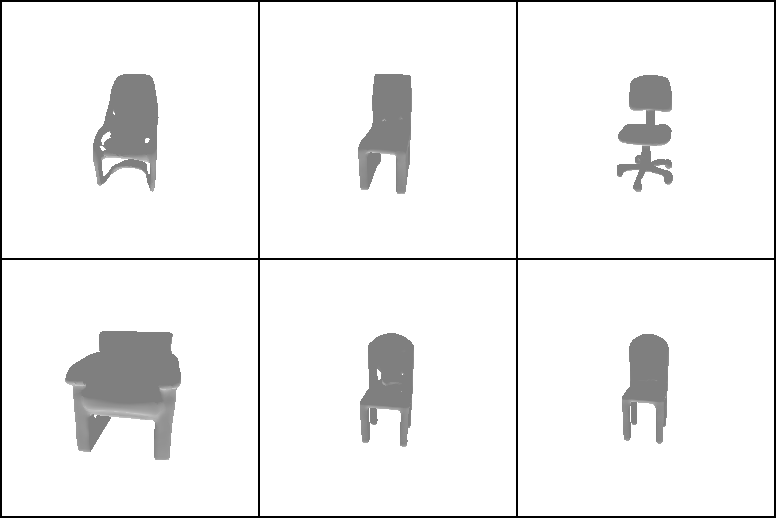

zmmawdxslpqzd chgytwveofmric kwfyrpuuyzpujplsstl ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: kwfyrpuuyzpujplsstl
Full Text: zmmawdxslpqzd chgytwveofmric kwfyrpuuyzpujplsstl
Saved: logs/bertV3/transformerv5-invalid-text/4-2-modelV5-zmmawdxslpqzd chgytwveofmric kwfyrpuuyzpujplsstl.gif


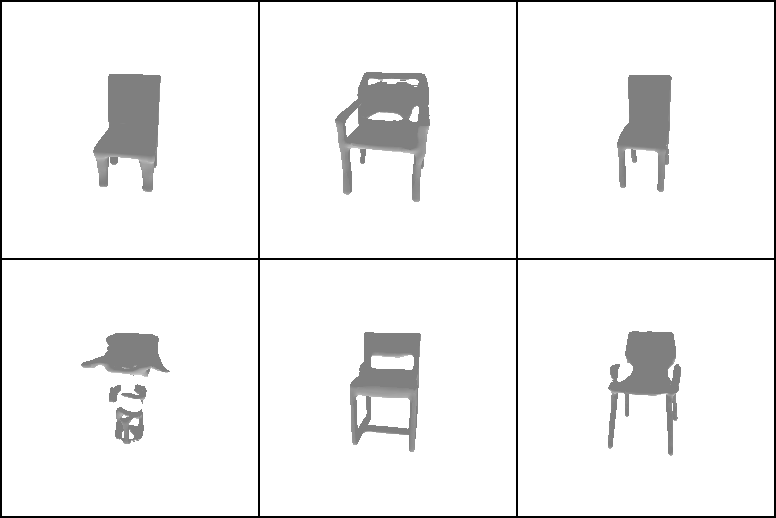

 38%|█████████████████████████▍                                        | 5/13 [01:46<02:50, 21.35s/it]

ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj
Full Text: ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj
Saved: logs/bertV3/transformerv5-invalid-text/5-0-modelV5-ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj.gif


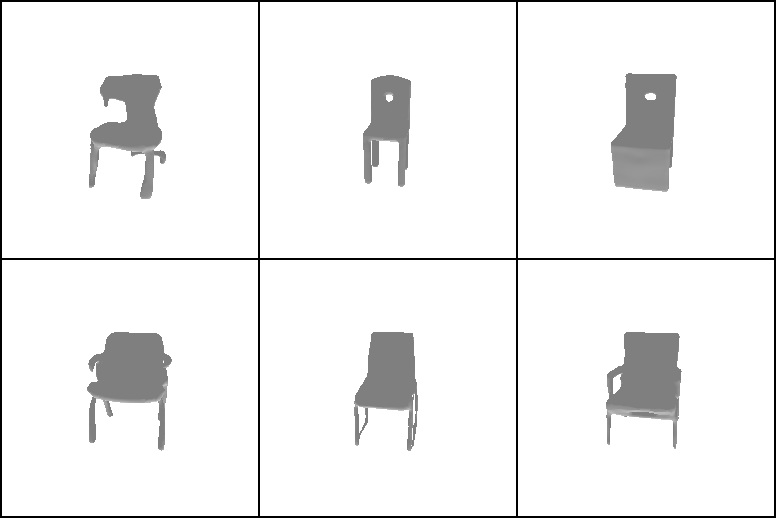

ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp
Full Text: ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp
Saved: logs/bertV3/transformerv5-invalid-text/5-1-modelV5-ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp.gif


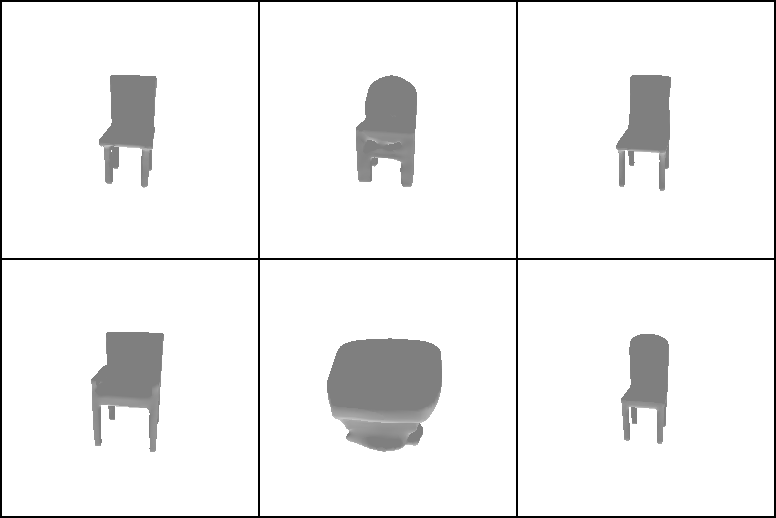

ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp mmliubhppjvvhfffyodzegjpvnwtlmrglsseozuuvdtinz ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: mmliubhppjvvhfffyodzegjpvnwtlmrglsseozuuvdtinz
Full Text: ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp mmliubhppjvvhfffyodzegjpvnwtlmrglsseozuuvdtinz
Saved: logs/bertV3/transformerv5-invalid-text/5-2-modelV5-ouwlhyksalbksrxqudcpzyxkyczytcqtnnjsqjalsgozpxjnlobixjbirkocdodannpayqdmvcrheofamhj pueafcyhpwqgxcpogqeqzadhmiwkjnruyrkxxwlmkhtpmp mmliubhppjvvhfffyodzegjpvnwtlmrglsseozuuvdtinz.gif


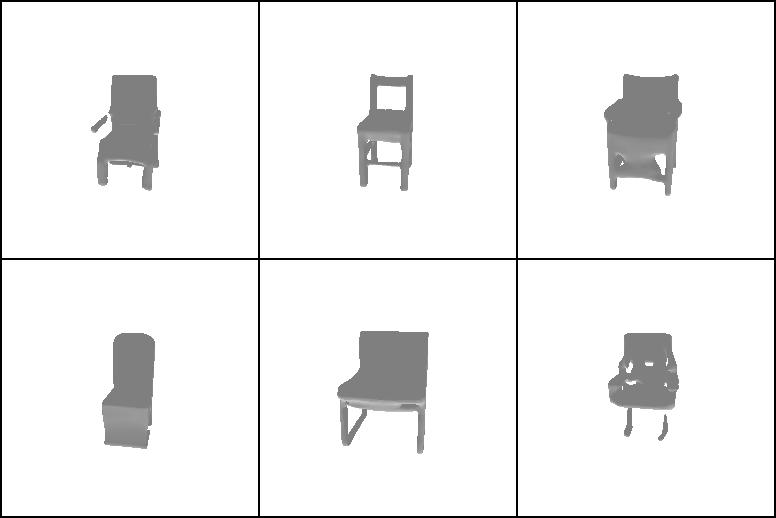

 46%|██████████████████████████████▍                                   | 6/13 [02:08<02:29, 21.36s/it]

hningswe ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: hningswe
Full Text: hningswe
Saved: logs/bertV3/transformerv5-invalid-text/6-0-modelV5-hningswe.gif


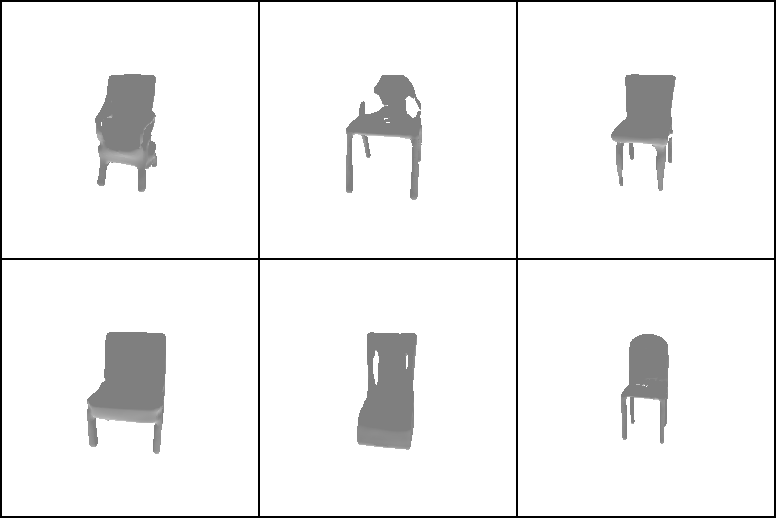

hningswe ofctnzalgqdrkbfurjql ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: ofctnzalgqdrkbfurjql
Full Text: hningswe ofctnzalgqdrkbfurjql
Saved: logs/bertV3/transformerv5-invalid-text/6-1-modelV5-hningswe ofctnzalgqdrkbfurjql.gif


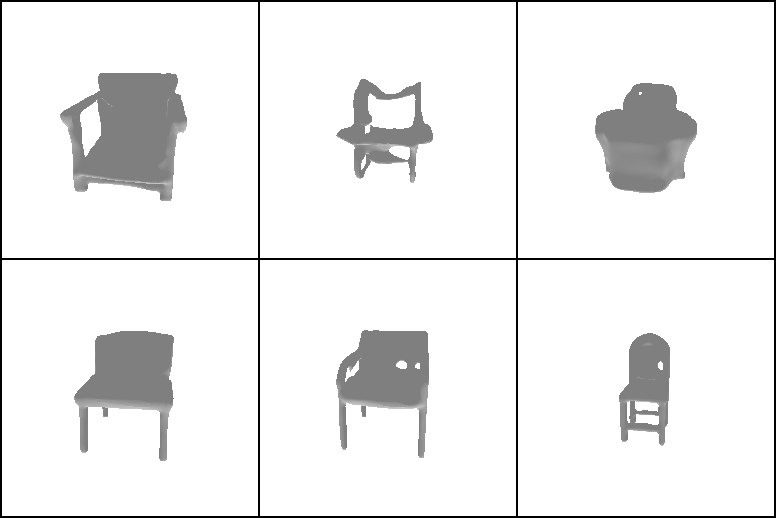

hningswe ofctnzalgqdrkbfurjql ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq
Full Text: hningswe ofctnzalgqdrkbfurjql ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq
Saved: logs/bertV3/transformerv5-invalid-text/6-2-modelV5-hningswe ofctnzalgqdrkbfurjql ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq.gif


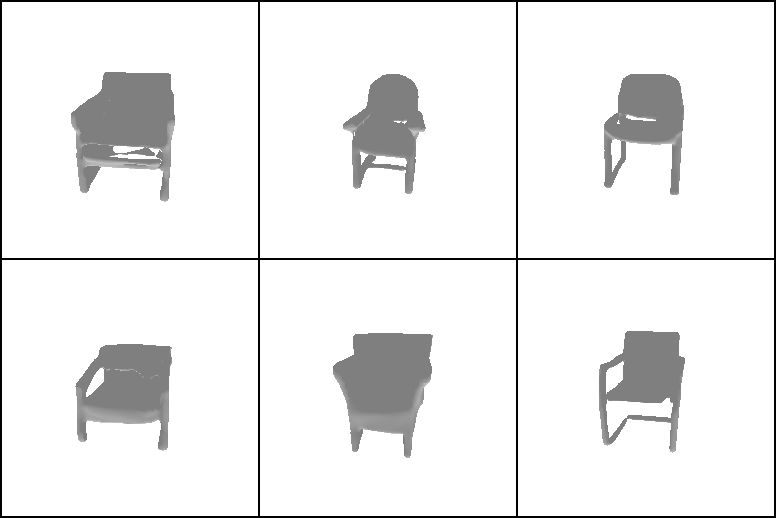

hningswe ofctnzalgqdrkbfurjql ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq ndqaosoihiwksanczxscjgowzklraes ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: ndqaosoihiwksanczxscjgowzklraes
Full Text: hningswe ofctnzalgqdrkbfurjql ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq ndqaosoihiwksanczxscjgowzklraes
Saved: logs/bertV3/transformerv5-invalid-text/6-3-modelV5-hningswe ofctnzalgqdrkbfurjql ltugwutvrdfknijwdpaajqbgblnfeyvxrkmhuytnprdcq ndqaosoihiwksanczxscjgowzklraes.gif


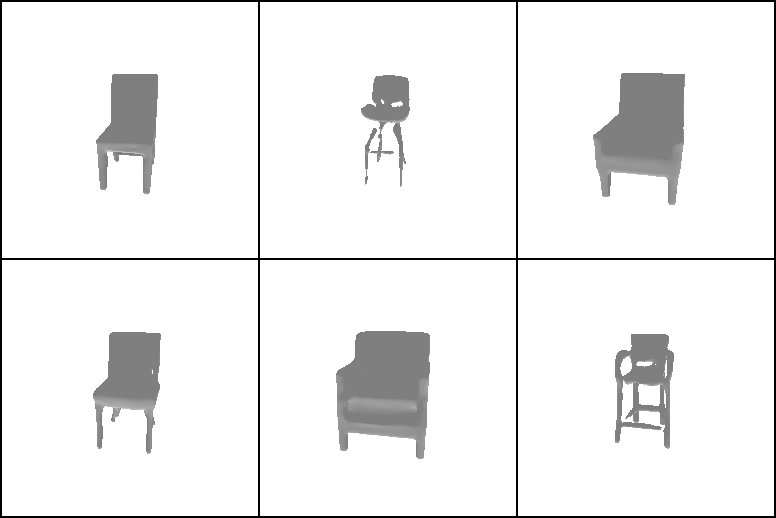

 54%|███████████████████████████████████▌                              | 7/13 [02:36<02:22, 23.75s/it]

btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi
Full Text: btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi
Saved: logs/bertV3/transformerv5-invalid-text/7-0-modelV5-btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi.gif


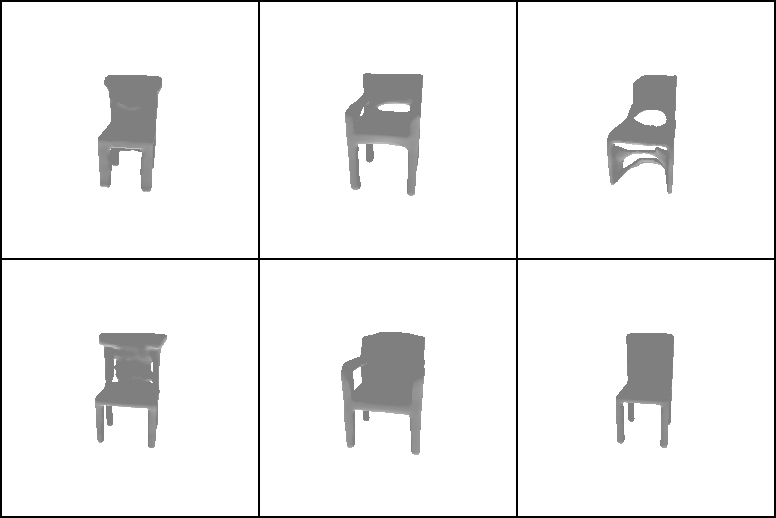

btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi ziaqbhputcbtoajebufqdohvoxpabicvafowabclseaui ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: ziaqbhputcbtoajebufqdohvoxpabicvafowabclseaui
Full Text: btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi ziaqbhputcbtoajebufqdohvoxpabicvafowabclseaui
Saved: logs/bertV3/transformerv5-invalid-text/7-1-modelV5-btmhtenmpwvlropuxfvhdwashaqlojnbxkowmi ziaqbhputcbtoajebufqdohvoxpabicvafowabclseaui.gif


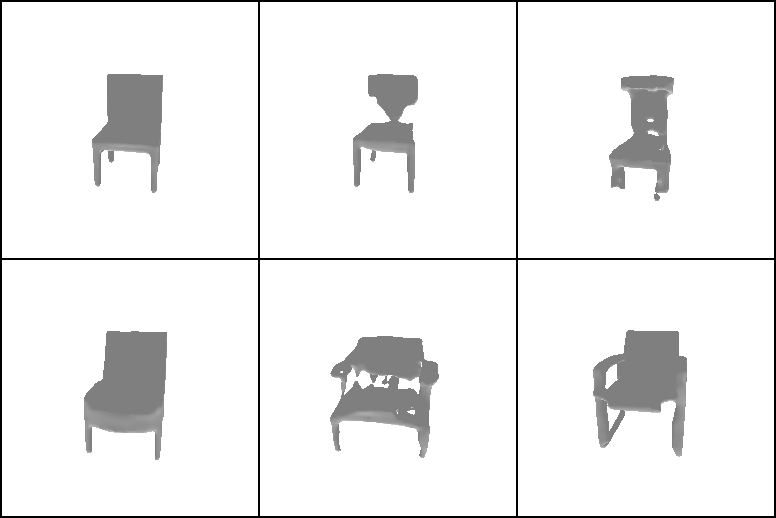

 62%|████████████████████████████████████████▌                         | 8/13 [02:51<01:43, 20.76s/it]

zrpvtfydckjobknewwfelgrt ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: zrpvtfydckjobknewwfelgrt
Full Text: zrpvtfydckjobknewwfelgrt
Saved: logs/bertV3/transformerv5-invalid-text/8-0-modelV5-zrpvtfydckjobknewwfelgrt.gif


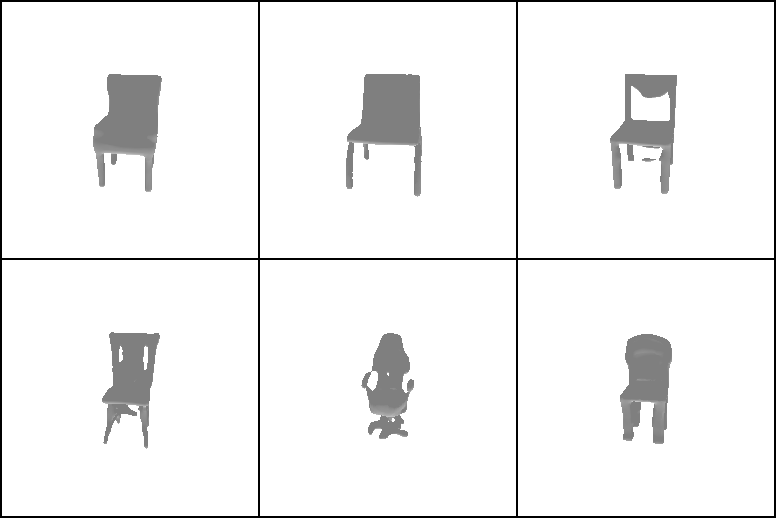

zrpvtfydckjobknewwfelgrt shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni
Full Text: zrpvtfydckjobknewwfelgrt shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni
Saved: logs/bertV3/transformerv5-invalid-text/8-1-modelV5-zrpvtfydckjobknewwfelgrt shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni.gif


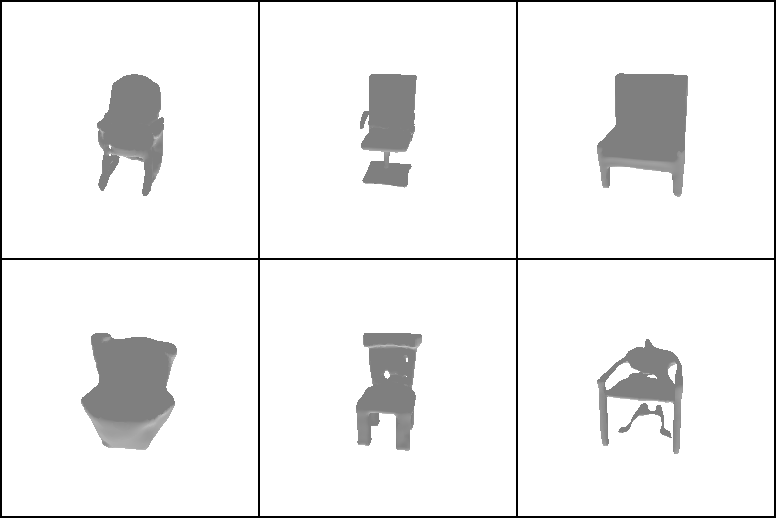

zrpvtfydckjobknewwfelgrt shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni uqzgqqhpkokjvwxcvwccroputyywpzlcijvffkhrdgcntrkho ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: uqzgqqhpkokjvwxcvwccroputyywpzlcijvffkhrdgcntrkho
Full Text: zrpvtfydckjobknewwfelgrt shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni uqzgqqhpkokjvwxcvwccroputyywpzlcijvffkhrdgcntrkho
Saved: logs/bertV3/transformerv5-invalid-text/8-2-modelV5-zrpvtfydckjobknewwfelgrt shetwzddqnrxhyshxbyividsrdwgxvuqanoupxkatwrpfvjsokhvellkni uqzgqqhpkokjvwxcvwccroputyywpzlcijvffkhrdgcntrkho.gif


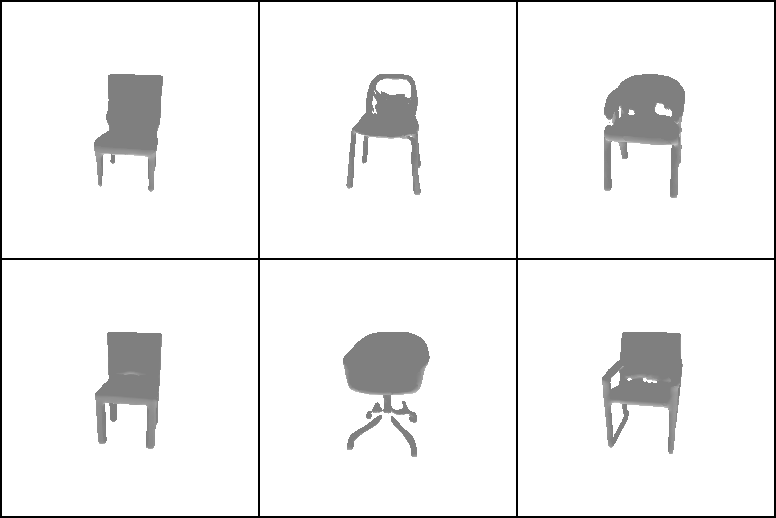

 69%|█████████████████████████████████████████████▋                    | 9/13 [03:12<01:23, 20.94s/it]

wvxduqkyensizcbgtioutyoxchfht ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: wvxduqkyensizcbgtioutyoxchfht
Full Text: wvxduqkyensizcbgtioutyoxchfht
Saved: logs/bertV3/transformerv5-invalid-text/9-0-modelV5-wvxduqkyensizcbgtioutyoxchfht.gif


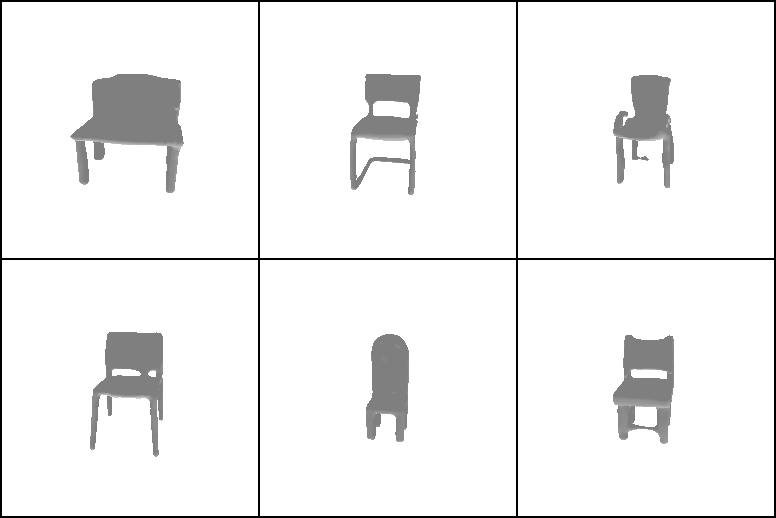

wvxduqkyensizcbgtioutyoxchfht qrjlmfhonzdkg ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: qrjlmfhonzdkg
Full Text: wvxduqkyensizcbgtioutyoxchfht qrjlmfhonzdkg
Saved: logs/bertV3/transformerv5-invalid-text/9-1-modelV5-wvxduqkyensizcbgtioutyoxchfht qrjlmfhonzdkg.gif


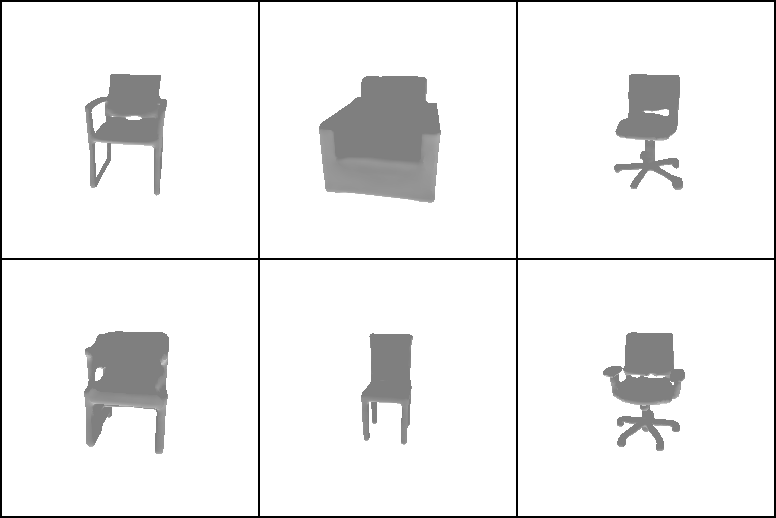

wvxduqkyensizcbgtioutyoxchfht qrjlmfhonzdkg vfufxuoqwgxnvtptpdcpercpkzltppgooetsuljkeehiaotrinnlewipcaidq ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: vfufxuoqwgxnvtptpdcpercpkzltppgooetsuljkeehiaotrinnlewipcaidq
Full Text: wvxduqkyensizcbgtioutyoxchfht qrjlmfhonzdkg vfufxuoqwgxnvtptpdcpercpkzltppgooetsuljkeehiaotrinnlewipcaidq
Saved: logs/bertV3/transformerv5-invalid-text/9-2-modelV5-wvxduqkyensizcbgtioutyoxchfht qrjlmfhonzdkg vfufxuoqwgxnvtptpdcpercpkzltppgooetsuljkeehiaotrinnlewipcaidq.gif


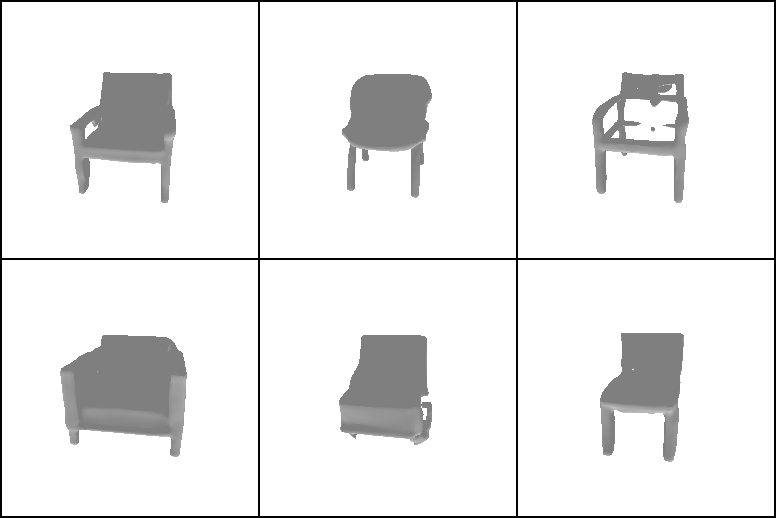

 77%|██████████████████████████████████████████████████               | 10/13 [03:33<01:03, 21.07s/it]

feoqspzackfu ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: feoqspzackfu
Full Text: feoqspzackfu
Saved: logs/bertV3/transformerv5-invalid-text/10-0-modelV5-feoqspzackfu.gif


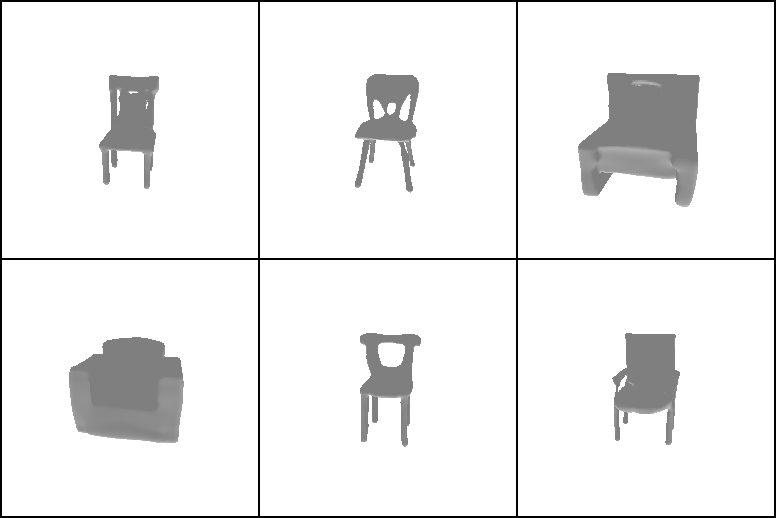

feoqspzackfu oklimowqk ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: oklimowqk
Full Text: feoqspzackfu oklimowqk
Saved: logs/bertV3/transformerv5-invalid-text/10-1-modelV5-feoqspzackfu oklimowqk.gif


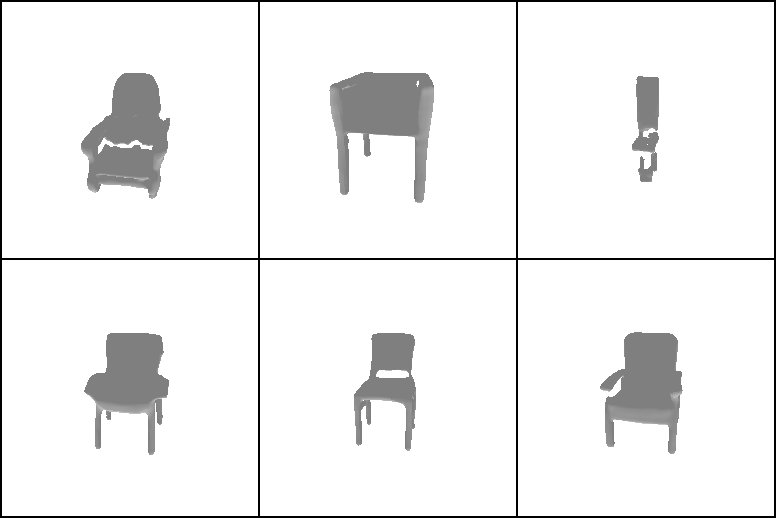

feoqspzackfu oklimowqk yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw
Full Text: feoqspzackfu oklimowqk yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw
Saved: logs/bertV3/transformerv5-invalid-text/10-2-modelV5-feoqspzackfu oklimowqk yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw.gif


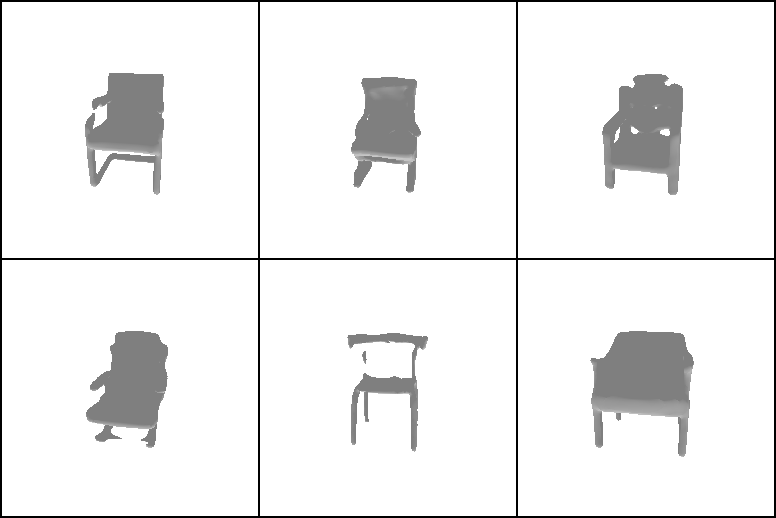

feoqspzackfu oklimowqk yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw djliahqxtwxvswggkb ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: djliahqxtwxvswggkb
Full Text: feoqspzackfu oklimowqk yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw djliahqxtwxvswggkb
Saved: logs/bertV3/transformerv5-invalid-text/10-3-modelV5-feoqspzackfu oklimowqk yayrnkcxsdjlfciaaczupfyzkkcmfwowwoocbgrjchw djliahqxtwxvswggkb.gif


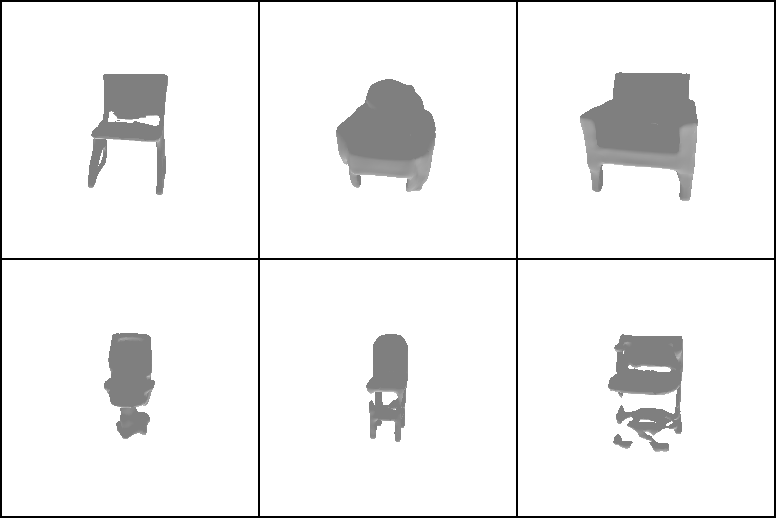

 85%|███████████████████████████████████████████████████████          | 11/13 [04:02<00:46, 23.38s/it]

qzohyihumweirocmbynlgi ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: qzohyihumweirocmbynlgi
Full Text: qzohyihumweirocmbynlgi
Saved: logs/bertV3/transformerv5-invalid-text/11-0-modelV5-qzohyihumweirocmbynlgi.gif


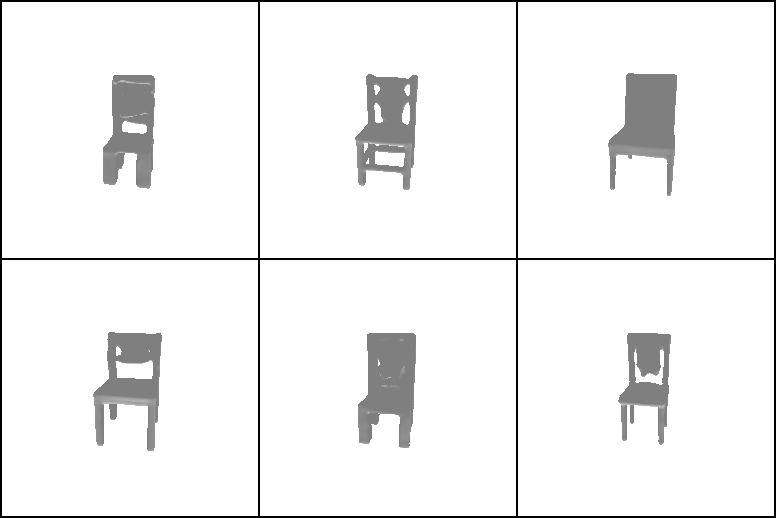

qzohyihumweirocmbynlgi kmckyuaxliohh ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: kmckyuaxliohh
Full Text: qzohyihumweirocmbynlgi kmckyuaxliohh
Saved: logs/bertV3/transformerv5-invalid-text/11-1-modelV5-qzohyihumweirocmbynlgi kmckyuaxliohh.gif


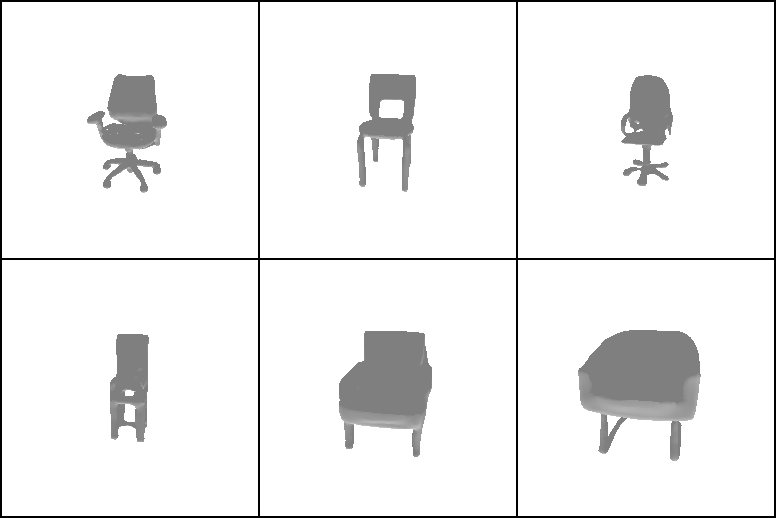

 92%|████████████████████████████████████████████████████████████     | 12/13 [04:16<00:20, 20.64s/it]

imwhtwtbldziitkmvnzbypfhyr ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: imwhtwtbldziitkmvnzbypfhyr
Full Text: imwhtwtbldziitkmvnzbypfhyr
Saved: logs/bertV3/transformerv5-invalid-text/12-0-modelV5-imwhtwtbldziitkmvnzbypfhyr.gif


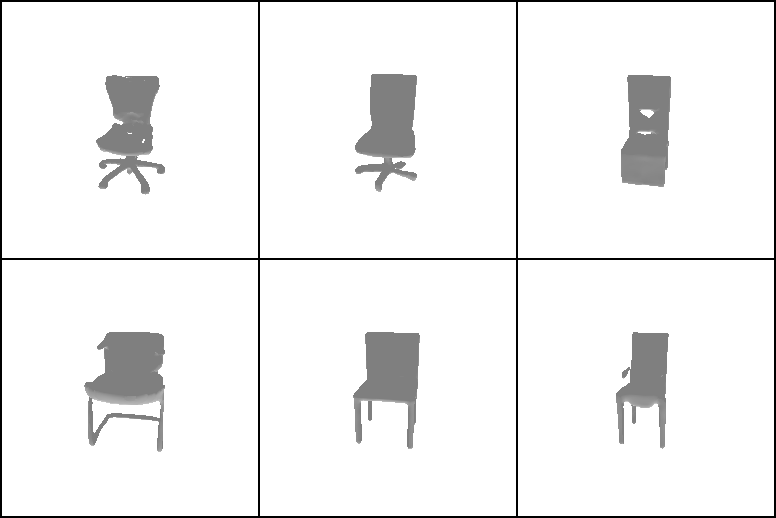

imwhtwtbldziitkmvnzbypfhyr tjhrcmwusjsirofsadm ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: tjhrcmwusjsirofsadm
Full Text: imwhtwtbldziitkmvnzbypfhyr tjhrcmwusjsirofsadm
Saved: logs/bertV3/transformerv5-invalid-text/12-1-modelV5-imwhtwtbldziitkmvnzbypfhyr tjhrcmwusjsirofsadm.gif


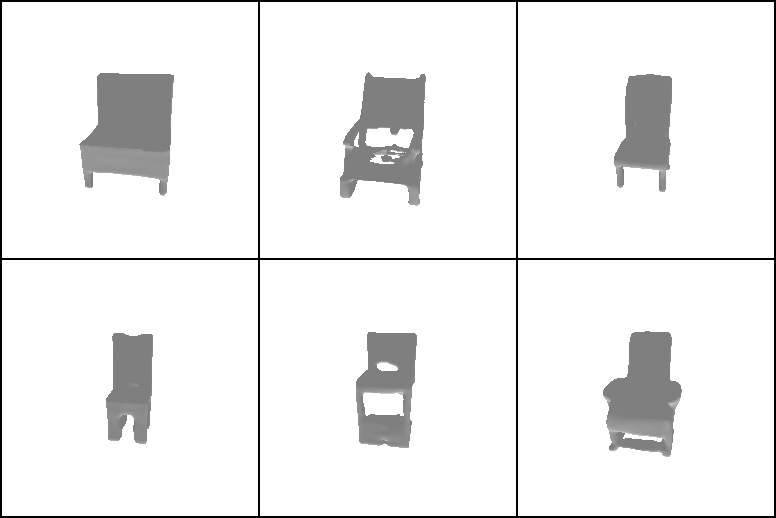

imwhtwtbldziitkmvnzbypfhyr tjhrcmwusjsirofsadm zelrnnuqmrjohyfepru ALL TEXt


[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: zelrnnuqmrjohyfepru
Full Text: imwhtwtbldziitkmvnzbypfhyr tjhrcmwusjsirofsadm zelrnnuqmrjohyfepru
Saved: logs/bertV3/transformerv5-invalid-text/12-2-modelV5-imwhtwtbldziitkmvnzbypfhyr tjhrcmwusjsirofsadm zelrnnuqmrjohyfepru.gif


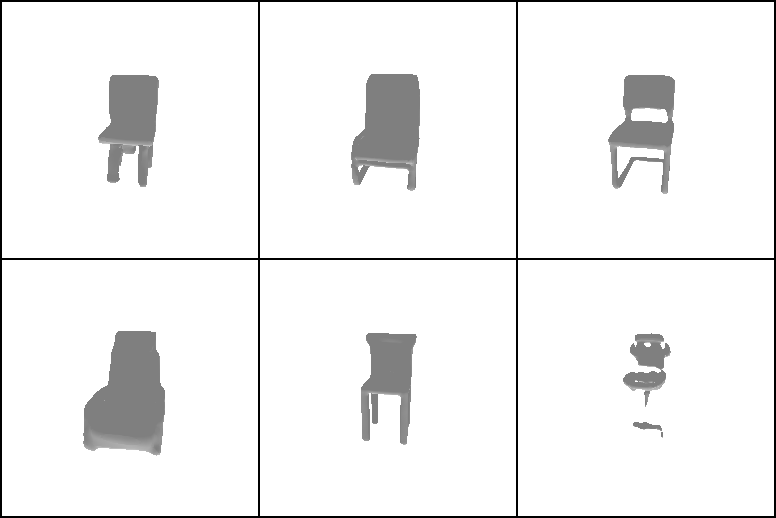

100%|█████████████████████████████████████████████████████████████████| 13/13 [04:38<00:00, 21.40s/it]


In [32]:
seed_everything(111)
counter="newest-bert"
description = "bertV3-transformerv5-invalid text"
res_dir = f"logs/bertV3/transformerv5-invalid-text"
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
#nimgs=3

class Opt:
    def __init__(self):
        self.name = 'opt'


model = modelV5
model_name = "modelV5"
bert2vq = bert2vqV3
import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange


nimgs=6
for j in tqdm(range(len(sequences_random))):
#for j in range(10):
    #text = sequence[j]
        sequence = sequences_random[j]
        last_text = ""
        z1 = torch.full((1,8,8,8,512), 1/512).cuda()
        test_data = { }
        sampler = torch.distributions.categorical.Categorical(z1)
        codeix = sampler.sample()
    
        z1  = z1.repeat_interleave(nimgs, dim=0)
        test_data["z_set"] = z1
        #test_data["z_set"] = shapeset[4]["z_set"].unsqueeze(0).repeat_interleave(nimgs, dim=0)
   
        test_data["idx"] = sampler.sample().repeat_interleave(nimgs, axis=0).cpu()
        test_data["z_q"] = z1
        #z1 =  z1.repeat_interleave(nimgs, dim=0)
        print("======================================================================================================")
        for i in range(len(sequence)):
    #for i in range(10):
        #text = input("Enter text")
            text = sequence[i]
            all_text = last_text + text
            text_conditional = text
            print(all_text,"ALL TEXt")
            #import pdb;pdb.set_trace()
            z1 = bert2vq([text] * nimgs, z1)
            z1 = torch.clamp(z1, 1e-3)
            topk = 20
            #import pdb;pdb.set_trace()
            test_data["z_set"] = z1
            sampler = torch.distributions.categorical.Categorical(z1)
            test_data["idx"] = torch.cat( [sampler.sample().cpu()], dim=0)
            #import pdb;pdb.set_trace()
            model.inference(test_data, topk=topk, prob=None, gen_order=None)
            #z1 = model.outp_concat.reshape((nimgs,8,8,8,512))

            print(test_data["idx"].shape)
            gen_mesh = sdf_to_mesh(model.x_recon_tf)
    
            gen_gif_name = f'{res_dir}/{j}-{i}-{model_name}-{all_text}.gif'
            try:
                save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
            except:
                import pdb;pdb.set_trace()
            last_text = all_text + " "
        
            print("TEXT:", text_conditional)
            print("Full Text:", all_text)
            print("Saved:", gen_gif_name)
            for name in [gen_gif_name]:
                display(ipy_image(name))

#  For Tranformer Models V0&V4

In [54]:
dict6[0].sum().item() == dict7[0].sum().item()

True

In [65]:
dict6[0]

tensor([[[[[4.3229e-03, 4.9106e-04, 5.2312e-04,  ..., 5.3962e-04,
            5.2696e-04, 5.1258e-04],
           [2.4096e-03, 2.6889e-04, 3.8150e-04,  ..., 4.1027e-04,
            2.6767e-04, 3.5789e-04],
           [8.6896e-03, 4.6045e-04, 5.8563e-04,  ..., 5.7201e-04,
            3.8977e-04, 4.5099e-04],
           ...,
           [3.1877e-03, 5.1905e-04, 5.3679e-04,  ..., 5.9480e-04,
            5.1602e-04, 3.9524e-04],
           [2.2499e-03, 8.1876e-04, 7.8614e-04,  ..., 6.4108e-04,
            4.8477e-04, 7.3999e-04],
           [3.9103e-03, 1.5448e-03, 1.4812e-03,  ..., 1.1646e-03,
            1.0670e-03, 1.3167e-03]],

          [[1.1058e-03, 1.2104e-04, 8.6268e-05,  ..., 1.4988e-04,
            6.6234e-05, 8.3382e-05],
           [9.3488e-04, 9.0092e-06, 7.5504e-06,  ..., 9.0610e-06,
            6.9981e-06, 6.9270e-06],
           [1.9095e-03, 3.0712e-06, 4.3539e-06,  ..., 3.7758e-06,
            3.1822e-06, 2.7895e-06],
           ...,
           [2.0214e-04, 2.4384e-05, 2.3

In [63]:
dict7[1] - dict6[1]


tensor([[[[[ 1.2061e-07, -4.9593e-08,  3.8999e-08,  ...,  1.2340e-08,
             6.7172e-08, -4.6566e-09],
           [ 1.5105e-08, -3.9348e-08, -2.5611e-08,  ...,  9.5693e-08,
             1.5076e-07,  2.3516e-08],
           [ 1.6520e-08,  6.6822e-08, -6.8685e-08,  ..., -4.9826e-08,
             2.1188e-08,  6.2631e-08],
           ...,
           [ 3.9436e-09, -1.5879e-07,  9.2434e-08,  ..., -1.4505e-07,
             1.4179e-07, -1.1455e-07],
           [-7.4913e-08,  2.7474e-08, -8.7777e-08,  ..., -2.8405e-08,
            -1.5541e-07, -1.9325e-07],
           [ 8.5623e-08, -7.4506e-09,  3.4459e-08,  ...,  4.0862e-08,
            -1.3749e-07,  4.8196e-08]],

          [[ 5.7262e-09, -6.4261e-08, -4.7497e-08,  ..., -2.2002e-07,
             6.5542e-08, -1.1199e-07],
           [ 1.0525e-08, -7.7067e-08,  3.2713e-08,  ..., -3.0850e-07,
            -5.2853e-08,  9.7905e-08],
           [-6.3446e-09,  8.9407e-08, -4.0163e-08,  ..., -1.5786e-07,
             1.2550e-07,  8.1258e-08],
 

In [24]:
z2 = torch.full((1,8,8,8,512), 1/512).cuda()
z3 = torch.full((1,8,8,8,512), -1).cuda()

output1 = bert2vqV3(["thin legs"],z2)
output2 = bert2vqV3(["round arms"],z2)
output1.shape
output2.shape


output3 =  bert2vqV3.bert_model.encode(["thin legs"])
output4 = bert2vqV3.bert_model.encode(["round arms"])
#bert2vqV3
output3 = torch.Tensor(output3)
output4 = torch.Tensor(output4)

# bert2 = bert2vqV0
# import torch.nn.functional as F
# def get_lang_prob_recursive(bert_model,test_data, z1, opt=None):
#     lang_logits = bert_model(test_data, z1)
#     lang_logprob = F.softmax(lang_logits, dim=1) # compute the prob. of next ele
#     # img_logprob = torch.sum(img_logprob, dim=1) # multiply the image priors
#     lang_logprob = rearrange(lang_logprob, 'bs c d h w -> (d h w) bs c')
#     return lang_logprob

In [61]:
p1 = get_lang_prob_recursive(bert2, "legs", z2).flatten()
p2 = get_lang_prob_recursive(bert2, "A chair12412512516 6236231626124 1251251261254125 6136161261261", z2).flatten()
# p3 = get_lang_prob_recursive(bert2vqV0, "The text chair is very good what should i do", z2).flatten()
# p4 = get_lang_prob_recursive(bert2vqV0, "No it is not please stay where you are", z3).flatten()

p5 = bert2("", z2).flatten()
p6 = bert2("test not nnow plzszzz yousssef youssef souasfsaf", z3).flatten()
p7 = bert2vqV1("HI THERE NOOO", z2).flatten()
p8 = bert2vqV1("OKAY NOPE", z3).flatten()

In [10]:

cos = torch.nn.CosineSimilarity(dim=-1)

In [26]:
#p2.shape
#cos(p1,p2)

cos(output1.flatten(),output2.flatten())


tensor(0.8803, device='cuda:0', grad_fn=<DivBackward0>)

In [35]:

cos(p7,p8)

tensor(0.9739, device='cuda:0', grad_fn=<DivBackward0>)

In [49]:
(torch.abs(p5)-torch.abs(p6)).sum()

tensor(1810.9578, device='cuda:0', grad_fn=<SumBackward0>)

In [65]:
p5[0:20]

tensor([ -2.4716,  -4.6048,  -6.3197,  -7.2726,  -7.0609,  -6.1544,  -4.6174,
         -2.4150,  -4.6388,  -8.5620, -11.9115, -13.5352, -13.3573, -11.6910,
         -8.7267,  -4.5131,  -6.2039, -11.6039, -15.9520, -18.0697],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [64]:
p6[0:20]

tensor([ -2.5593,  -4.7741,  -6.5130,  -7.4405,  -7.2514,  -6.3244,  -4.7222,
         -2.4639,  -4.7713,  -8.8515, -12.2152, -13.8216, -13.6694, -11.9634,
         -8.9204,  -4.6222,  -6.3759, -11.9415, -16.3353, -18.4551],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [58]:
bert2.weights

AttributeError: 'BERT2VQ' object has no attribute 'weights'

In [33]:
pip install GPUtil

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=05db05bc2681686f5274f0bf20550cd18a040b5d93806ab1950dfddb7cab11b3
  Stored in directory: /rhome/streakfull/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.


In [16]:
from GPUtil import showUtilization as gpu_usage


In [17]:
gpu_usage() 
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)
# gpu_usage()
    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 92% |


In [21]:
torch.cuda.empty_cache()


In [23]:
!pip install numba

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 18.5 MB/s eta 0:00:0000:0100:01
